In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
!cp 'drive/My Drive/data_road.zip' 'data_road.zip'

In [11]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "data_road.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!')

File Name                                             Modified             Size
data_road/testing/                             2020-07-01 14:37:02            0
data_road/testing/calib/                       2020-07-01 14:37:18            0
data_road/testing/calib/um_000000.txt          2020-07-01 14:37:10         1860
data_road/testing/calib/um_000001.txt          2020-07-01 14:37:10         1860
data_road/testing/calib/um_000002.txt          2020-07-01 14:37:10         1860
data_road/testing/calib/um_000003.txt          2020-07-01 14:37:10         1860
data_road/testing/calib/um_000004.txt          2020-07-01 14:37:10         1860
data_road/testing/calib/um_000005.txt          2020-07-01 14:37:10         1861
data_road/testing/calib/um_000006.txt          2020-07-01 14:37:10         1860
data_road/testing/calib/um_000007.txt          2020-07-01 14:37:10         1860
data_road/testing/calib/um_000008.txt          2020-07-01 14:37:10         1860
data_road/testing/calib/um_000009.txt   

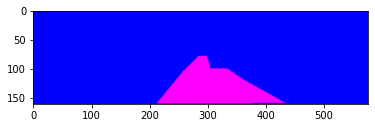

In [12]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


gt_image = cv2.imread("data_road/training/gt_image_2/uu_road_000042.png")

gt_image = cv2.resize(gt_image,(576,160))

#background_color = np.array([255, 0, 0])

#gt_bg = np.all(gt_image == background_color, axis=2)
#gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
#gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)


imgplot = plt.imshow(gt_image)

imgplot

In [16]:

import cv2
import math
import os
import re
from glob import glob

from keras.utils import Sequence

import numpy as np
import scipy.misc
from keras.preprocessing.image import load_img
from imgaug import augmenters as iaa


class DataSequence(Sequence):

    def __init__(self, data_dir, batch_size, image_shape):
        """
        Keras Sequence object to train a model on larger-than-memory data.
            @:param: data_dir: directory in which we have got the kitti images and the corresponding masks
            @:param: batch_size: define the number of training samples to be propagated.
            @:param: image_shape: shape of the input image
        """

        self.batch_size = batch_size
        self.image_shape = image_shape
        self.image_paths = glob(os.path.join(data_dir, 'image_2', '*.png'))
        self.label_paths = {
            re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
            for path in glob(os.path.join(data_dir, 'gt_image_2', '*_road_*.png'))}
        self.sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        self.aug_pipe = iaa.Sequential(
            [
                iaa.SomeOf((0, 5),
                           [
                               iaa.OneOf([
                                   iaa.GaussianBlur((0, 3.0)),  # blur images with a sigma between 0 and 3.0
                                   iaa.AverageBlur(k=(2, 7)),
                                   # blur image using local means with kernel sizes between 2 and 7
                                   iaa.MedianBlur(k=(3, 11)),
                                   # blur image using local medians with kernel sizes between 2 and 7
                               ]),
                               iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # sharpen images

                               iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
                               iaa.OneOf([
                                   iaa.Dropout((0.01, 0.1), per_channel=0.5),  # randomly remove up to 10% of the pixels
                               ]),
                               iaa.Add((-10, 10), per_channel=0.5),
                               # change brightness of images (by -10 to 10 of original value)
                               iaa.Multiply((0.5, 1.5), per_channel=0.5),
                               iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),  # improve or worsen the contrast
                           ],
                           random_order=True
                           )
            ],
            random_order=True
        )

    def __len__(self):
        """
        Number of batch in the Sequence.
        :return: The number of batches in the Sequence.
        """
        return int(math.ceil(len(self.image_paths) / float(self.batch_size)))

    def get_batch_images(self, idx, path_list):
        """
        :param idx: position of the image in the Sequence.
        :param path_list: list that consists of all the image paths
        :return: Retrieve the images in batches
        """
        # Fetch a batch of images from a list of paths
        for im in path_list[idx * self.batch_size: (1 + idx) * self.batch_size]:
            # load the image and resize
            image = cv2.imread(im)
            
            image = cv2.resize(image,(self.image_shape[0], self.image_shape[1]))

            #image = scipy.misc.imresize(image, (self.image_shape[1], self.image_shape[0]))
            # augment the image
            image = self.aug_pipe.augment_image(image)
            return np.array([image])


    def get_batch_labels(self, idx, path_list):

        """
        Retrieve the masks in batches
        :param idx: position of the mask in the Sequence.
        :param path_list: list that consists of all the mask paths
        :return: mask labels
        """
        # iterate and map the mask labels for the respective images
        for im in path_list[idx * self.batch_size: (1 + idx) * self.batch_size]:
            gt_image_file = self.label_paths[os.path.basename(im)]

            gt_image = cv2.imread(gt_image_file)
            
            gt_image = cv2.resize(gt_image,(self.image_shape[0], self.image_shape[1]))

            #gt_image = load_img(gt_image_file)
            #gt_image = scipy.misc.imresize(gt_image, (self.image_shape[1], self.image_shape[0]))
            background_color = np.array([0, 0, 255])
            gt_bg = np.all(gt_image == background_color, axis=2)
            gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
            gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)
            return np.array([gt_image])

    def __getitem__(self, idx):
        """
        Retrieve the mask and the image in batches at position idx
        :param idx: position of the batch in the Sequence.
        :return: batches of image and the corresponding mask
        """
        batch_x = self.get_batch_images(idx, self.image_paths)
        batch_y = self.get_batch_labels(idx, self.image_paths)
        return batch_x, batch_y

In [17]:
from keras import Input, Model
from keras.layers import Conv2D, MaxPooling2D, concatenate, BatchNormalization, PReLU, SpatialDropout2D, Add, Conv2DTranspose, ReLU, Activation, Permute, ZeroPadding2D, UpSampling2D, Dense, Reshape, Concatenate


class UNET():

    def __init__(self, input_size, nclasses):
        """
        :param input_size:  shape of the input image
        :param nclasses: number of classes
        """

        self.im_width = input_size[0]
        self.im_height = input_size[1]
        self.nclasses = nclasses

    def make_conv_block(self, nb_filters, input_tensor, block):
        """
        :param nb_filters: number of filters
        :param input_tensor: input tensor to perform convolution
        :param block: block number
        :return:
        """

        def make_stage(input_tensor, stage):
            name = 'conv_{}_{}'.format(block, stage)
            x = Conv2D(nb_filters, (3, 3), activation='relu',
                       padding='same', name=name)(input_tensor)
            name = 'batch_norm_{}_{}'.format(block, stage)
            x = BatchNormalization(name=name)(x)
            x = Activation('relu')(x)
            return x

        x = make_stage(input_tensor, 1)
        x = make_stage(x, 2)
        return x

    def build(self):
        """
        Build the model for training
        """
        print('. . . . .Building UNET. . . . .')

        inputs = Input(shape=(self.im_height, self.im_width, 3))
        conv1 = self.make_conv_block(32, inputs, 1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = self.make_conv_block(64, pool1, 2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = self.make_conv_block(128, pool2, 3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = self.make_conv_block(256, pool3, 4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

        conv5 = self.make_conv_block(512, pool4, 5)

        up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv4])
        conv6 = self.make_conv_block(256, up6, 6)

        up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv3])
        conv7 = self.make_conv_block(128, up7, 7)

        up8 = Concatenate()([UpSampling2D(size=(2, 2))(conv7), conv2])
        conv8 = self.make_conv_block(64, up8, 8)

        up9 = Concatenate()([UpSampling2D(size=(2, 2))(conv8), conv1])
        conv9 = self.make_conv_block(32, up9, 9)

        conv10 = Conv2D(self.nclasses, (1, 1), name='conv_10_1')(conv9)

        x = Reshape((self.im_width * self.im_height, self.nclasses))(conv10)
        x = Activation('softmax')(x)
        outputs = Reshape((self.im_height, self.im_width, self.nclasses))(x)

        model = Model(inputs=inputs, outputs=outputs)

        print(model.summary())

        print('. . . . .Build Compeleted. . . . .')

        return model

In [ ]:
unet = UNET((576,160),2)

unet.build()

. . . . .Building UNET. . . . .
. . . . .Build Compeleted. . . . .


In [21]:

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.optimizers import adam

from keras import callbacks



"""
Model Factory that fetches the corresponding model based on the backend that has been defined
and initiates the training process
:param backend: define the backbone architecture for the training
:param input_size: the size of the input image
:param nb_classes: the number of classes
"""
input_size = (576,160)
nb_classes = 2


feature_extractor = UNET(input_size, nb_classes).build()



"""
  Train the model based on the training configurations
:param train_configs: Configuration for the training
"""
optimizer = adam(learning_rate=1e-5)
train_times = 8

# Data sequence for training
sequence = DataSequence("data_road/training",10,input_size)
steps_per_epoch = len(sequence) * train_times

# configure the model for training

feature_extractor.compile(optimizer=optimizer, loss='categorical_crossentropy',
                                metrics=['accuracy'])

# define the callbacks for training
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='Unet.h5', monitor='acc',
                      save_best_only='True',
                      save_weights_only='True', verbose=2)
es = EarlyStopping(mode='max', monitor='acc', patience=6, verbose=1)
model_reducelr = callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=0.05 * 1e-5)

callback = [tb, mc, es, model_reducelr]

# Train the model on data generated batch-by-batch by the DataSequence generator
feature_extractor.fit_generator(sequence,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=100
                                ,
                                      verbose=1,
                                      shuffle=True, callbacks=callback,
                                      workers=3,
                                      max_queue_size=8
                                      )

. . . . .Building UNET. . . . .
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 160, 576, 3)  0                                            
__________________________________________________________________________________________________
conv_1_1 (Conv2D)               (None, 160, 576, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_norm_1_1 (BatchNormalizat (None, 160, 576, 32) 128         conv_1_1[0][0]                   
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 160, 576, 32) 0           batch_norm_1_1[0][0]             
____________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.452430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


232/232 [==============================] - 31s 133ms/step - loss: 0.7424 - accuracy: 0.6121
Epoch 2/100


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


232/232 [==============================] - 26s 113ms/step - loss: 0.6063 - accuracy: 0.7077
Epoch 3/100
232/232 [==============================] - 26s 113ms/step - loss: 0.5200 - accuracy: 0.7600
Epoch 4/100
232/232 [==============================] - 26s 113ms/step - loss: 0.4589 - accuracy: 0.7961
Epoch 5/100
232/232 [==============================] - 26s 113ms/step - loss: 0.4259 - accuracy: 0.8133
Epoch 6/100
232/232 [==============================] - 26s 113ms/step - loss: 0.3956 - accuracy: 0.8339
Epoch 7/100
232/232 [==============================] - 26s 113ms/step - loss: 0.3677 - accuracy: 0.8496
Epoch 8/100
232/232 [==============================] - 26s 113ms/step - loss: 0.3399 - accuracy: 0.8689
Epoch 9/100
232/232 [==============================] - 26s 113ms/step - loss: 0.3194 - accuracy: 0.8805
Epoch 10/100
232/232 [==============================] - 26s 113ms/step - loss: 0.2954 - accuracy: 0.8907
Epoch 11/100
232/232 [==============================] - 26s 112ms/step - lo

[[[9.63464260e-01 3.65356877e-02]
  [9.77727056e-01 2.22728886e-02]
  [9.54402030e-01 4.55979817e-02]
  ...
  [9.65875685e-01 3.41243707e-02]
  [9.68540311e-01 3.14597189e-02]
  [9.25400853e-01 7.45991245e-02]]

 [[9.63331103e-01 3.66689600e-02]
  [9.93941188e-01 6.05882844e-03]
  [9.88581240e-01 1.14188073e-02]
  ...
  [9.94562447e-01 5.43750823e-03]
  [9.85756814e-01 1.42431585e-02]
  [9.36813474e-01 6.31865114e-02]]

 [[9.84218538e-01 1.57814566e-02]
  [9.90983605e-01 9.01642349e-03]
  [9.89647210e-01 1.03527643e-02]
  ...
  [9.99546468e-01 4.53521498e-04]
  [9.96988118e-01 3.01188766e-03]
  [9.58260953e-01 4.17390019e-02]]

 ...

 [[7.60161221e-01 2.39838749e-01]
  [9.52835858e-01 4.71641161e-02]
  [9.48971152e-01 5.10288030e-02]
  ...
  [9.95347083e-01 4.65297233e-03]
  [9.85752046e-01 1.42479120e-02]
  [9.47122574e-01 5.28774261e-02]]

 [[8.91853511e-01 1.08146489e-01]
  [8.99918854e-01 1.00081176e-01]
  [9.48469460e-01 5.15305996e-02]
  ...
  [9.93846953e-01 6.15307689e-03]
  [9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


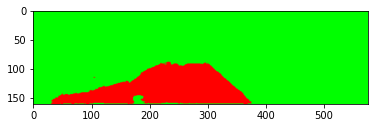

In [24]:
from keras_preprocessing import image
import numpy as np

img = cv2.imread("data_road/training/image_2/um_000040.png")

img = cv2.resize(img,(576,160))

x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)

pred = feature_extractor.predict(x)

pred = pred[0]

output = np.zeros((160,576,3))

print(pred)

for i in range(160):

  for j in range(576):

    index = np.argmax(pred[i][j])

    if index == 0:

      output[i][j] = np.array([0,255,0])
    
    else:

      output[i][j] = np.array([255,0,0])

#plt.imshow(img)

plt.imshow(output)

plt.show()

In [25]:
feature_extractor.save('segment_road.h5')

In [26]:
!mv 'segment_road.h5' 'drive/My Drive/segment_road.h5'

In [3]:
!cp 'drive/My Drive/segment_road.h5' 'segment_road.h5'

In [4]:
from google.colab import files
uploaded = files.upload()

Saving proj_chal_vid.mp4 to proj_chal_vid.mp4


In [5]:
from tensorflow.python.keras.models import Model, load_model

model = load_model('segment_road.h5')

In [78]:
from moviepy.editor import VideoFileClip, ImageSequenceClip
import numpy as np
import cv2
from keras_preprocessing import image

def pipeline(image, video=True):
    alpha = 0.2
    dims = image.shape
    x = cv2.resize(image, (576, 160))

    x = np.expand_dims(x, axis=0)

    pred = model.predict(x)

    pred = pred[0]

    print(pred.shape)

    mask = np.zeros((160,576,3))

    for i in range(160):

      for j in range(576):

        index = np.argmax(pred[i][j])

        if index == 1:

          mask[i][j][0] = 255
    

    img_color = x[0].copy()   

    print(type(img_color))
    print(type(mask))
    colored_mask = img_color.copy()

    #cv2.addWeighted(mask, alpha, img_color, 1-alpha, 0, img_color)

    img_color = (img_color*0.6) + (mask*0.4)

    #plt.imshow(img_color.astype('uint8'))

    #plt.show()
    
    if video:
        
        return img_color
    
    #return img_color, colored_mask

(160, 576, 2)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


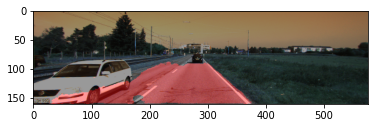

In [79]:
img = cv2.imread("data_road/training/image_2/um_000040.png")

pipeline(img)
